In [ ]:
# Standard library imports (built-in modules)
import os
import sys
import json
import yaml
import h5py
import random
from pathlib import Path
from typing import Tuple, Any, Optional

# Third-party libraries (numerical computing, data processing, and visualization)
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

# Whole Slide Imaging (WSI) processing
import openslide  

# Data visualization and specialized plots
from pySankey.sankey import sankey

# FastAI for deep learning
from fastai.vision.all import *

# Custom libraries (ensure correct path for project-specific utilities)
sys.path.append('/scratch_tmp/users/k21066795/RandStainNA')
from randstainna import RandStainNA

sys.path.append("/scratch_tmp/users/k21066795/BreastAgeNet")
from utils_model import *
from utils_vis import *

In [12]:
NR_raw = pd.read_csv("/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/main/test_full/test_NR_clean_10repeats.csv", low_memory=False)
NR_df = get_averaged_outputs(NR_raw)
NR_df

,wsi_id,patient_id,cohort,source,age,age_group,branch_0,branch_1,branch_2,sigmoid_0,sigmoid_1,sigmoid_2,binary_0,binary_1,binary_2,final_prediction
0,17063888_FPE_2,17063888,KHP,RM,29,0,-0.045889,-2.077632,-6.186151,0.488530,0.111290,0.002054,0,0,0,0
1,3002 A6,3002,BCI,RM,31,0,1.608087,0.708061,-0.153674,0.833146,0.669973,0.461657,1,1,0,2
2,18000286_FPE_5,18000286,KHP,RM,31,0,0.657071,-2.272796,-5.149375,0.658602,0.093401,0.005770,1,0,0,1
4,18000006_FPE_2,18000006,KHP,RM,31,0,0.023464,-2.170264,-5.823433,0.505866,0.102453,0.002949,1,0,0,1
5,17063887_FPE_4,17063887,KHP,RM,29,0,-1.083033,-3.273628,-6.739735,0.252933,0.036487,0.001182,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36948,Human_129_s01,Human_129_s01,EPFL,RM,18,0,0.600201,-0.380661,-2.738144,0.645702,0.405968,0.060760,1,0,0,1
37198,Human_131_s01,Human_131_s01,EPFL,RM,39,1,0.591480,-0.383484,-2.750609,0.643705,0.405287,0.060052,1,0,0,1
37448,Human_172_s01,Human_172_s01,EPFL,RM,32,0,0.600201,-0.380661,-2.738144,0.645702,0.405968,0.060760,1,0,0,1
37698,Human_188_s01,Human_188_s01,EPFL,RM,17,0,0.586905,-0.384966,-2.757148,0.642655,0.404930,0.059684,1,0,0,1


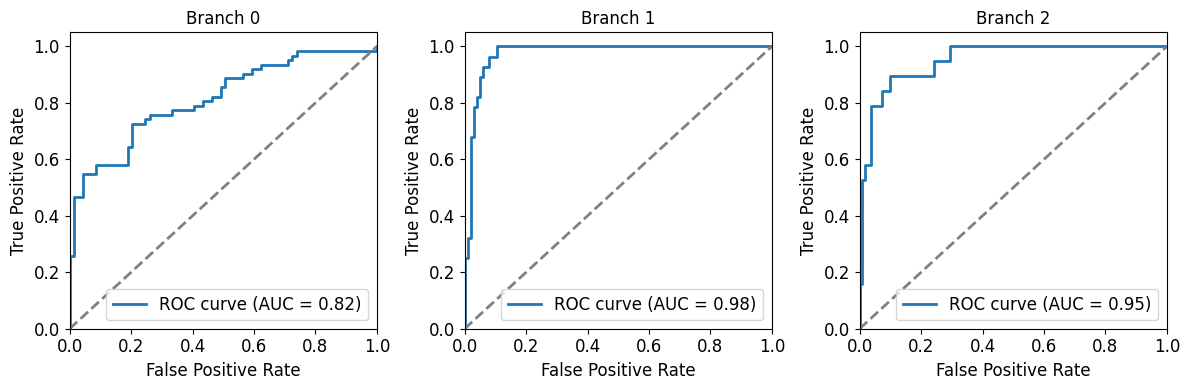

In [13]:
# AUC of each branch prediction
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
branch_ROC(NR_df, branch=0, class_name=">35y", ax=axes[0], fontsize=12, line_thickness=2)
branch_ROC(NR_df, branch=1, class_name=">45y", ax=axes[1], fontsize=12, line_thickness=2)
branch_ROC(NR_df, branch=2, class_name=">55y", ax=axes[2], fontsize=12, line_thickness=2)
plt.tight_layout()
save_pt = '/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/evaluation/Test_NR_multiple_ROCs.pdf'
plt.savefig(save_pt, format='pdf')
plt.show()

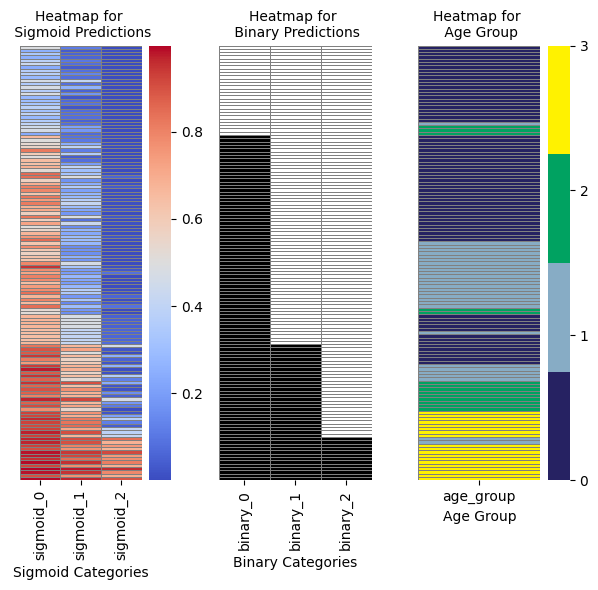

In [14]:
NR_df = NR_df.sort_values(by=["binary_0", "binary_1", "binary_2"], ascending=[True, True, True])
save_pt = '/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/evaluation/Test_NR_branch_predictions.pdf'
vis_branch_predictions(NR_df, save_pt=save_pt)

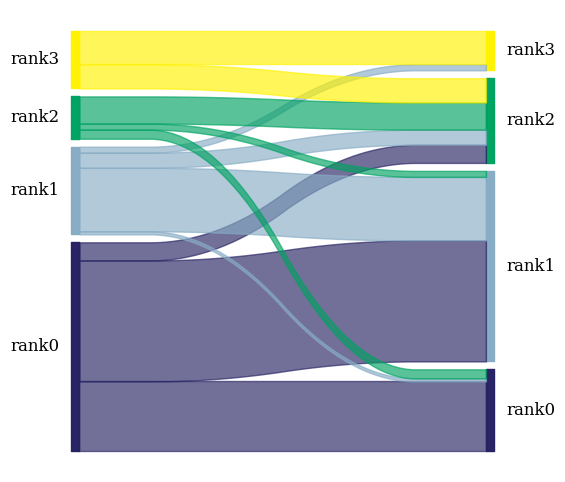

In [20]:
y_true = [f"rank{i}" for i in list(NR_df["age_group"])]
y_pred = [f"rank{i}" for i in list(NR_df["final_prediction"])]

colors = {
    'rank0': "#262262",
    'rank1': "#87ACC5",
    'rank2': "#00A261",
    'rank3': "#FFF200"
}


# Create Sankey diagram
sankey(y_true, y_pred, aspect=20, colorDict=colors, fontsize=12)
plt.savefig('/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/evaluation/Test_NR_sankey.pdf', format="pdf", dpi=300, transparent=True)

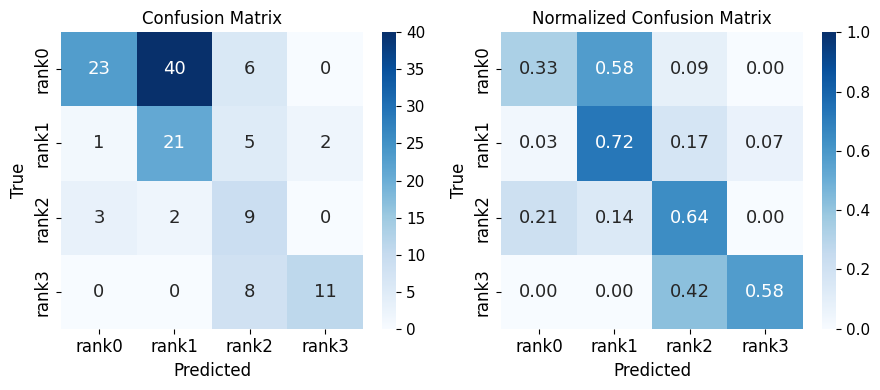

In [171]:
# plot confusion matrix
y_true = [f"rank{i}" for i in NR_df.loc[:, "age_group"].values]
y_pred = [f"rank{i}" for i in NR_df.loc[:, "final_prediction"].values]

fig, axes = plt.subplots(1, 2, figsize=(9, 4))  # 1 row, 2 columns
plot_cm(y_true, y_pred, fontsize=12, save_pt='/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/evaluation/Test_NR_cm.pdf', ax=axes[0])
plot_cm_norm(y_true, y_pred, fontsize=12, save_pt='/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/evaluation/Test_NR_cm_prop.pdf', ax=axes[1])
plt.tight_layout()
plt.show()

/tmp/ipykernel_1463989/939581493.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(patient_ids_sorted, fontsize=10, rotation=90)


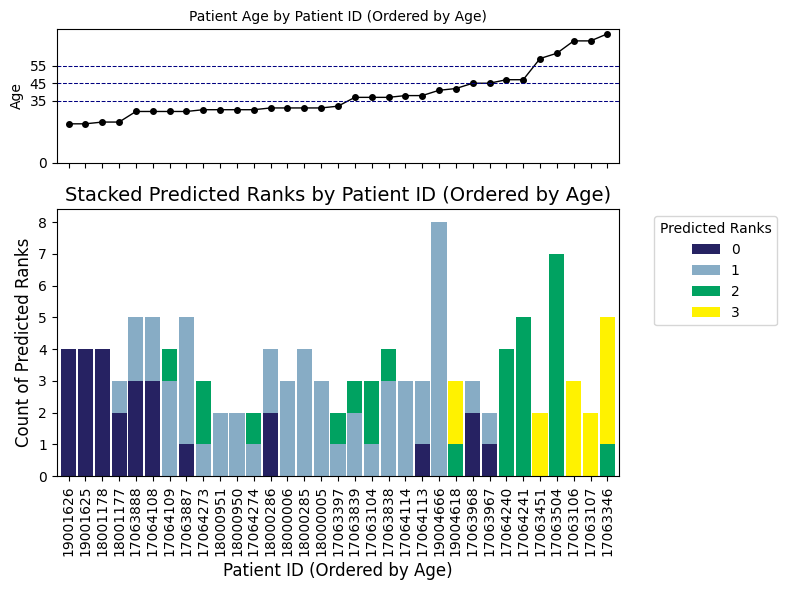

In [67]:
save_pt = '/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/evaluation/Test_NR_patientLevel_barplot.pdf'
patient_id_counts = NR_df['patient_id'].value_counts()
patient_ids_more_than_once = patient_id_counts[patient_id_counts > 1].index
NR_multiple = NR_df[NR_df['patient_id'].isin(patient_ids_more_than_once)].copy()
barplot_multiple_WSIs(NR_multiple, save_pt)

/tmp/ipykernel_1463989/825988116.py:22: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x="Sample Size", y="MAE", data=mae_df, estimator=np.mean, color='navy',


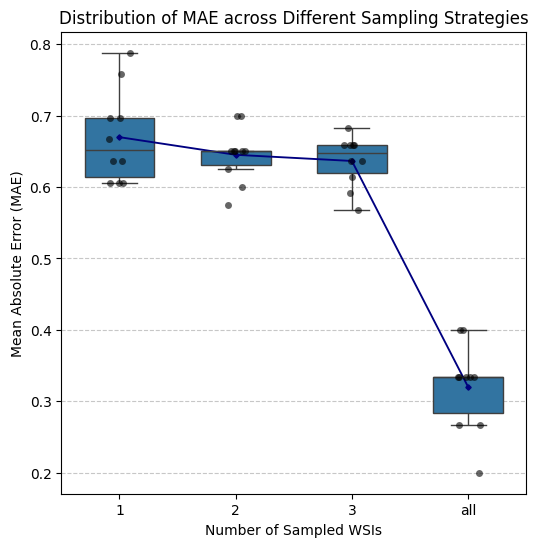

In [167]:
patient_level_df = compute_patient_level_predictions(NR_multiple)


mae_results = []
for repetition in range(10):
    for sample_size in [1, 2, 3, "all"]:
        filtered_df = patient_level_df[(patient_level_df['sample_size'] == sample_size) & (patient_level_df['repetition'] == repetition + 1)]
        
        mae = mean_absolute_error(filtered_df['age_group'], filtered_df['final_prediction'])
        mae_results.append({
            "Sample Size": sample_size,
            "Repetition": repetition + 1,
            "MAE": mae
        })
mae_df = pd.DataFrame(mae_results)



plt.figure(figsize=(6, 6))
sns.boxplot(x="Sample Size", y="MAE", data=mae_df, showfliers=False, width=0.6)
sns.stripplot(x="Sample Size", y="MAE", data=mae_df, jitter=True, color="black", alpha=0.6)
sns.pointplot(x="Sample Size", y="MAE", data=mae_df, estimator=np.mean, color='navy', 
              markers="D", scale=0.5, errorbar=None)

plt.xlabel("Number of Sampled WSIs", fontsize=10)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=10)
plt.title("Distribution of MAE across Different Sampling Strategies", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
save_pt = '/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/evaluation/Test_NR_multiple_slides_sampling_boxplot.pdf'
plt.savefig(save_pt, format='pdf')
plt.show()